# MLNS ASSIGNEMENT - MISSING LINK PREDICTION

## I - INITIALISING ENVIRONMENT

In [39]:
import numpy as np
import csv
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from dgl.nn import GraphConv
import torch.nn.functional as F

from sklearn.metrics.pairwise import cosine_similarity

In [2]:
node_info = pd.read_csv("../data/node_information.csv", header=None)
test_set = pd.read_csv("../data/test.txt", sep=" ", header=None, names=['source', 'target'])
train_set = pd.read_csv("../data/train.txt", sep=" ", header=None, names=['source', 'target', 'label'])

In [4]:
print(node_info.shape)
node_info.head(-5)

(3597, 933)


1    2    3    4    5    6    7    8    9    10   ...  923  924  925  \
0                                                       ...                  
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
5     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
6     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
7     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
7571  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
7572  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
7575  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
7576  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
7579  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

      926  927  928  929  930  931  932  
0                                        
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
5     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
6     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
7     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...   ...  ...  ...  ...  ...  ...  ...  
7571  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
7572  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
7575  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
7576  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
7579  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[3592 rows x 932 columns]

In [25]:
train_set

,source,target,label
0,939,3809,1
1,2442,5784,1
2,179,3809,1
3,857,2280,1
4,1358,5722,1
...,...,...,...
10491,81,6464,0
10492,4,6433,0
10493,3341,6717,1
10494,1562,4656,0


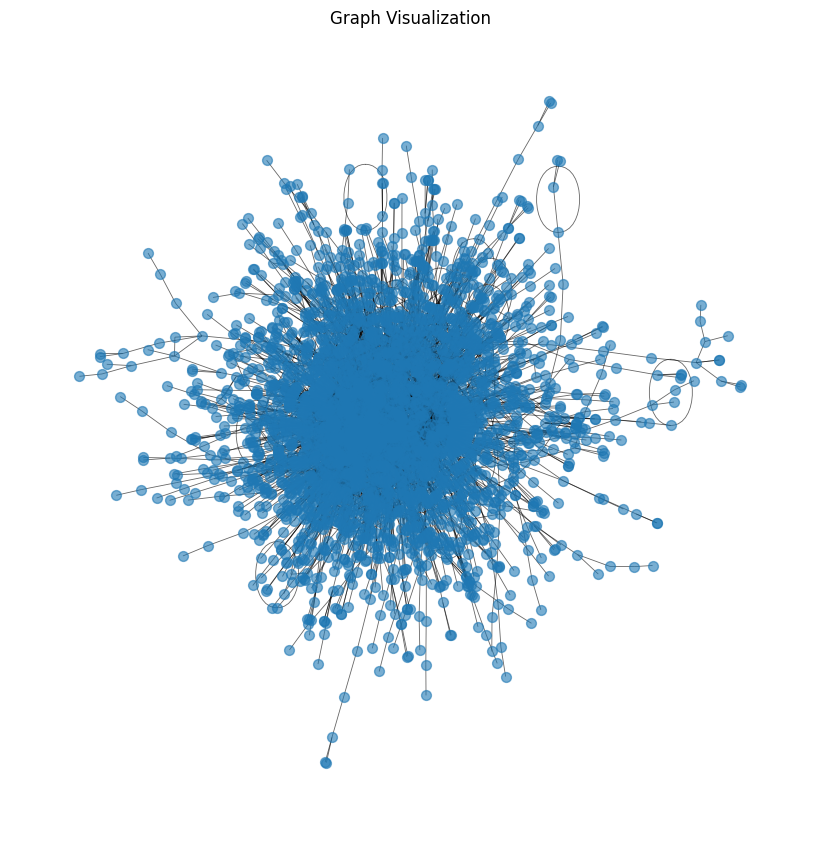

In [26]:
edges = train_set[train_set['label'] == 1][['source', 'target']].values.tolist()

G = nx.Graph()
G.add_edges_from(edges)

plt.figure(figsize=(8, 8))
nx.draw(G, with_labels=False, node_size = 50, alpha = 0.6, width = 0.6)
plt.title("Graph Visualization")
plt.show()

Number of nodes: 3597
Number of edges: 5248


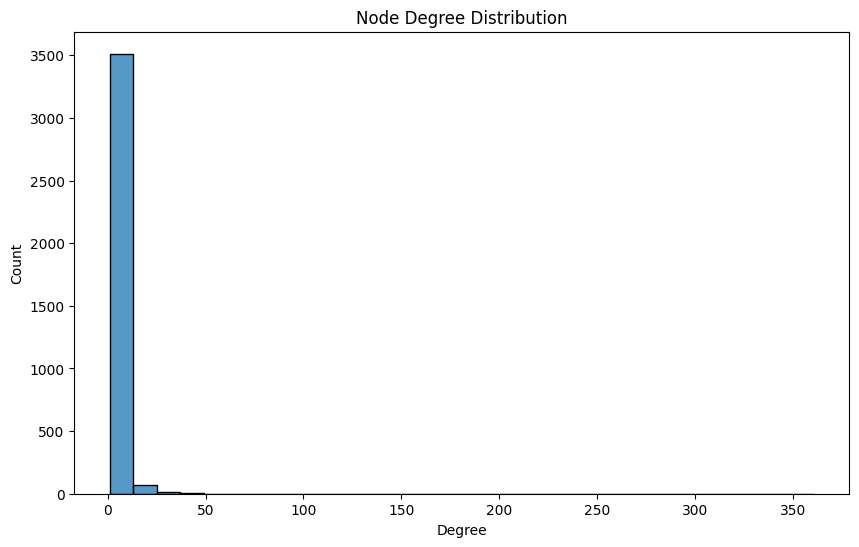

label
1    0.5
0    0.5
Name: proportion, dtype: float64


In [27]:
# Graph Information
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Node Degree Distribution
degrees = [G.degree(n) for n in G.nodes()]
plt.figure(figsize=(10, 6))
sns.histplot(degrees, kde=False, bins=30)
plt.title('Node Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.show()

# Label distribution
print(train_set['label'].value_counts(normalize=True))

## II - Feature Engineering

In [28]:
# Cosine Similarity
def calculate_cosine_similarity(node_encodings, source_node, target_node):
    source_vector = node_encodings.loc[source_node].values.reshape(1, -1)
    target_vector = node_encodings.loc[target_node].values.reshape(1, -1)
    return cosine_similarity(source_vector, target_vector)[0][0]

train_set['cosine_similarity'] = train_set.apply(lambda row: calculate_cosine_similarity(node_info, row['source'], row['target']), axis=1)

In [29]:
def common_neighbors(G, u, v):
        return len(list(nx.common_neighbors(G, u, v)))

train_set['common_neighbors'] = train_set.apply(lambda row: common_neighbors(G, row['source'], row['target']), axis=1)
train_set.head()

,source,target,label,cosine_similarity,common_neighbors
0,939,3809,1,0.000000,0
1,2442,5784,1,0.308607,1
2,179,3809,1,0.000000,2
3,857,2280,1,0.000000,0
4,1358,5722,1,0.288675,0


In [31]:
def split_dataset(N, train_ratio, seed=4):
    
    train_size = int(train_ratio * N)
    val_size = int((N - train_size)/2)
    test_size = N - train_size - val_size

    # split dataset
    subsets = torch.utils.data.random_split(range(N), lengths = [train_size, val_size, test_size], generator=torch.Generator().manual_seed(seed))
    train_inds, val_inds, test_inds = [torch.Tensor(subset.indices) for subset in subsets]

    # create tensors of masks for each subset
    dataset_inds = torch.arange(N)
    train_mask = torch.isin(dataset_inds, train_inds)
    val_mask = torch.isin(dataset_inds, val_inds)
    test_mask = torch.isin(dataset_inds, test_inds)

    return train_mask, val_mask, test_mask

N = G.number_of_nodes()
train_mask, val_mask, test_mask = split_dataset(N, train_ratio=0.8)

## III - Data Modelling

In [47]:
X = train_set[['source', 'target', 'cosine_similarity', 'common_neighbors']]
y = train_set[['label']]
num_classes = 2
num_feat = X.shape[1]

G_dgl = dgl.from_networkx(G)
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.long).squeeze()

### a) Random Baseline

In [15]:
###################
# random baseline #
###################

# Load test samples 
with open("test.txt", "r") as f:
    reader = csv.reader(f)
    test_set = list(reader)
test_set = [element[0].split(" ") for element in test_set]

# Make random predictions
random_predictions = np.random.choice([0, 1], size=len(test_set))
random_pred = zip(np.array(range(len(test_set))), random_predictions)

# note: Kaggle requires that you add "ID" and "category" column headers

with open("random_predictions.csv","w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(i for i in ["ID", "Predicted"])
    for row in random_pred:
         csv_out.writerow(row)
    pred.close()

### b) Graph Neural Network

In [40]:
class GNN_model(torch.nn.Module):
    """
    Define a Graph Convolution Network 
    """
    def __init__(self, num_layers, input_size, hidden_size, output_size, dropout):
        super(GNN_model, self).__init__()

        # Define GNN components
        self.convs = torch.nn.ModuleList() # holds GraphConv layers in a list
        self.convs.append(
            GraphConv(input_size, hidden_size, activation=F.relu)) # You can either define the activation at the layer level or call it inside the forward
        for i in range(num_layers-2):
            self.convs.append(
                GraphConv(hidden_size, hidden_size, activation=F.relu))
        self.convs.append(GraphConv(hidden_size, output_size))

        self.dropout = dropout

    def forward(self, graph, x):
        # Implement the forward function that takes the graph,
        # the features tensor x and returns the output tensor as shown in figure 1
        for conv in self.convs:
            x = conv(graph, x)
    
        output = F.log_softmax(x, dim=1) # Log_softmax is more stable numerically in comparison to softmax
        return output

In [35]:
def train(model, graph, x, labels, num_epochs, optimizer, train_mask, val_mask, test_mask):
    """ Train the GNN model 

    Args:
        model: GNN model defined in pytorch
        graph (dgl.graph): dataset on which the task is performed
        x (tensor): node feature matrix 
        labels (tensor): node labels
        num_epochs (int): number of epochs
        optimizer: Adam optimizer
        train_mask (tensor): boolean mask for training nodes
        val_mask (tensor): boolean mask for validation set
    """
    
    # Train the model (pytorch specific)
    best_val_acc = 0
    best_test_acc = 0
    nll_loss = torch.nn.NLLLoss()

    model.train()
    for epoch in range(num_epochs):
        # Forward
        pred = model(graph, x)

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss = nll_loss(pred[train_mask], labels[train_mask])

        # Compute accuracy on training/validation/test
        pred = torch.argmax(pred, dim=1)
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print('Epoch {}: loss {:.3f}, train Acc: {:.3f}, val acc: {:.3f}, test acc: {:.3f}'.format(
                epoch, loss, train_acc, val_acc, test_acc))

In [41]:
# Instanciate model
num_layers=3
hidden_size=16
dropout=0.3
num_epochs=300
lr=0.01
weight_decay=0.005
train_ratio=0.8
seed=4

model = GNN_model(num_layers, num_feat, hidden_size, num_classes, dropout)

In [48]:
# Define an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=weight_decay)

# Train model
train(model, G_dgl, X, y, num_epochs, optimizer, train_mask, val_mask, test_mask)

RuntimeError: The size of tensor a (10496) must match the size of tensor b (3597) at non-singleton dimension 0